In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import re
from scipy import stats
import statsmodels.formula.api as smf
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# load npy file to pandas dataframe
data = np.load("../data/processed/surat_cleaned.npy", allow_pickle=True)
df = pd.DataFrame(data)

# 4. Question Formulation

## 4.2 Research Question 3: Pricing Uncertainty by Segment
**The Question**

Which market segments in Surat have the highest pricing uncertainty in `price_per_sqft`?
We quantify uncertainty using robust dispersion metrics (primarily IQR) computed on
`price_per_sqft_c` (clipped 1%–99%). Specifically:

Rank segments defined by `transaction` (New vs Resale) × `bhk_group` (1, 2, 3, 4+)
by their IQR of `price_per_sqft_c`.

Test whether dispersion differs significantly between New vs Resale within each `bhk_group`.

**Motivation & Benefits**
* **Why this is worth investigating:** Average prices alone do not capture market stability. Two segments may share similar medians but have very different spreads: one is predictable (stable pricing), the other is volatile (hard
to price, larger negotiation risk).
* **Insights provided:** 
  * A clear ranking of “most volatile” vs “most stable” segments using an outlier-robust spread metric.
  * Evidence on whether New and Resale markets differ in price dispersion for the same BHK size.
* **Stakeholders:**
    * Home buyers: understand where listing prices are less reliable and where negotiation may matter.
    * Agents / listing platforms: provide price ranges (confidence bands) rather than single-point prices.
    * Investors: identify segments with greater mispricing opportunities due to higher dispersion.
* **Real-world decision:** “Should I trust listing prices in this segment, or do I need more comparable checks and stronger negotiation because the market is noisy?”

# 5. Data analysis

## 5.1 Analysis for Question 3

#### A. Preprocessing
**Workflow**

1.  Choose a robust target for dispersion
    - Use `price_per_sqft_c` (clipped 1%–99%) to reduce the influence of extreme outliers.
    - Dispersion will be measured via IQR = Q3 − Q1, representing the middle 50% spread.
  
2.  Create segment labels
    - Create `bhk_group` as {1, 2, 3, 4+} for interpretable segment-level comparisons.
    - Standardize `transaction` to two main groups: New vs Resale (drop/label others if needed).
  
3.  Ensure adequate sample size per segment
    - Filter out segments with very small counts (e.g., n < 30) to avoid unstable IQR estimates.

4.  Prepare a modeling table
    - Keep only necessary columns: `price_per_sqft_c`, `transaction`, `bhk_group`.
    - Drop missing rows and report remaining sample size.

In [38]:
# Required columns: price_per_sqft, bhk, transaction
q3_df = df[["price_per_sqft", "bhk", "transaction"]].copy()

def clip_by_quantile(s, low=0.01, high=0.99):
    lo, hi = s.quantile(low), s.quantile(high)
    return s.clip(lo, hi)

q3_df["price_per_sqft_c"] = clip_by_quantile(df["price_per_sqft"])

# BHK groups for interpretability
q3_df["bhk_group"] = pd.cut(
    q3_df["bhk"],
    bins=[0, 1, 2, 3, 99],
    labels=["1", "2", "3", "4+"],
    right=True,
    include_lowest=True,
)

# Normalize transaction into two groups (edit mapping if your labels differ)
q3_df["transaction_group"] = np.where(
    q3_df["transaction"].str.contains("New Property"),
    "New Property",
    np.where(q3_df["transaction"].str.contains("Resale"), "Resale", np.nan),
)

# Drop rows with missing essentials
q3_df = q3_df.dropna(subset=["price_per_sqft_c", "bhk_group", "transaction_group"]).copy()

print("Rows for Q3:", len(q3_df))
q3_df[["transaction_group", "bhk_group"]].value_counts().sort_index()

Rows for Q3: 3003


transaction_group  bhk_group
New Property       1             22
                   2            268
                   3            642
                   4+           454
Resale             1            198
                   2            635
                   3            559
                   4+           225
Name: count, dtype: int64

In [39]:
min_n = 30

seg_counts = (
    q3_df.groupby(["transaction_group", "bhk_group"], observed=True)
    .size()
    .reset_index(name="n")
)

valid_segments = seg_counts[seg_counts["n"] >= min_n].copy()

q3_df = q3_df.merge(
    valid_segments[["transaction_group", "bhk_group"]],
    on=["transaction_group", "bhk_group"],
    how="inner",
)

print("Rows after min_n filter:", len(q3_df))
valid_segments.sort_values(["bhk_group", "transaction_group"])

Rows after min_n filter: 2981


,transaction_group,bhk_group,n
4,Resale,1,198
1,New Property,2,268
5,Resale,2,635
2,New Property,3,642
6,Resale,3,559
3,New Property,4+,454
7,Resale,4+,225


#### B. Analysis

* **Analytical approach**

We analyze pricing uncertainty using robust dispersion metrics:

1. Compute dispersion per segment:

    - For each segment (transaction_group × bhk_group), compute:

        - n, median, Q1, Q3, and IQR = Q3 − Q1.

    - Rank segments by IQR to identify the most volatile markets.

2. Test whether dispersion differs between New vs Resale

    - Within each bhk_group, compare the dispersion of price_per_sqft_c for New vs Resale.

    - Use Brown–Forsythe / Levene test centered at median (center="median") because it is robust to non-normal distributions and outliers (common in housing prices).

    - Report p-values to indicate whether the dispersion difference is statistically meaningful.

* **Expected outputs**

- Statistics tables

    - segment_dispersion: n, median, q1, q3, iqr per (`transaction_group`, `bhk_group`)

    - dispersion_tests: per bhk_group, Levene/Brown–Forsythe test statistic and p-value

    - iqr_ratio: per `bhk_group`, iqr_new / iqr_resale for practical magnitude comparison

- Visualizations

    - Bar chart of iqr by segment (`transaction_group` × `bhk_group`)

    - Boxplot of `price_per_sqft_c` by `transaction_group`, separated by `bhk_group`

- Interpretation targets

    - Identify which segments have the largest IQR (highest uncertainty)

    - Determine whether New vs Resale dispersion differs within each BHK group

    - Translate findings into practical implications (pricing reliability, negotiation risk)

In [40]:
def iqr(x: pd.Series) -> float:
    return float(x.quantile(0.75) - x.quantile(0.25))

segment_dispersion = (
    q3_df.groupby(["transaction_group", "bhk_group"], observed=True)["price_per_sqft_c"]
    .agg(
        n="size",
        median="median",
        q1=lambda s: s.quantile(0.25),
        q3=lambda s: s.quantile(0.75),
        iqr=iqr,
    )
    .reset_index()
    .sort_values("iqr", ascending=False)
)

segment_dispersion

,transaction_group,bhk_group,n,median,q1,q3,iqr
6,Resale,4+,225,5882.0,4563.00,8292.00,3729.00
2,New Property,4+,454,6111.0,5473.50,7197.75,1724.25
5,Resale,3,559,4511.0,3819.00,5227.50,1408.50
1,New Property,3,642,4788.0,4200.00,5501.75,1301.75
4,Resale,2,635,3644.0,3088.00,4309.00,1221.00
3,Resale,1,198,2986.5,2500.00,3526.25,1026.25
0,New Property,2,268,4051.0,3628.25,4400.75,772.50


In [41]:
bhk_order = ["1", "2", "3", "4+"]
sorted_bhks = sorted(q3_df["bhk_group"].unique(), key=lambda x: bhk_order.index(str(x)))

rows = []
for bhk in sorted_bhks:
    sub = q3_df[q3_df["bhk_group"] == bhk]
    new_vals = sub[sub["transaction_group"] == "New Property"]["price_per_sqft_c"].values
    resale_vals = sub[sub["transaction_group"] == "Resale"]["price_per_sqft_c"].values

    if len(new_vals) < 2 or len(resale_vals) < 2:
        continue

    # Brown–Forsythe / Levene test with median center
    stat, p = stats.levene(new_vals, resale_vals, center="median")

    iqr_new = np.quantile(new_vals, 0.75) - np.quantile(new_vals, 0.25)
    iqr_resale = np.quantile(resale_vals, 0.75) - np.quantile(resale_vals, 0.25)
    ratio = float(iqr_new / iqr_resale) if iqr_resale > 0 else np.nan

    rows.append({
        "bhk_group": str(bhk),
        "n_new": len(new_vals),
        "n_resale": len(resale_vals),
        "levene_stat": stat,
        "p_value": p,
        "iqr_new": float(iqr_new),
        "iqr_resale": float(iqr_resale),
        "iqr_ratio_new_over_resale": ratio,
    })

dispersion_tests = pd.DataFrame(rows).sort_values("bhk_group")
dispersion_tests

,bhk_group,n_new,n_resale,levene_stat,p_value,iqr_new,iqr_resale,iqr_ratio_new_over_resale
0,2,268,635,24.738596,7.861249e-07,772.50,1221.0,0.632678
1,3,642,559,29.208759,7.834130e-08,1301.75,1408.5,0.924210
2,4+,454,225,85.955007,2.421458e-19,1724.25,3729.0,0.462389


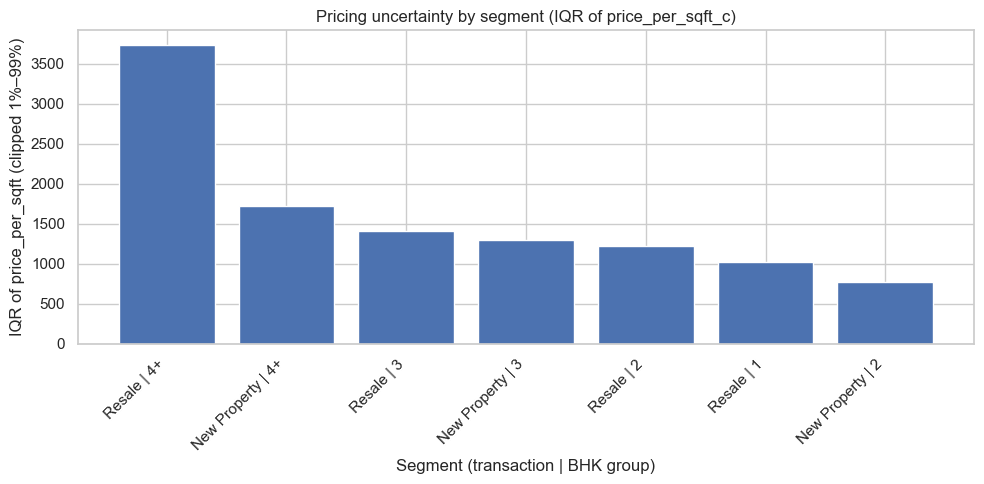

In [42]:
plot_df = segment_dispersion.copy()
plot_df["segment"] = plot_df["transaction_group"] + " | " + plot_df["bhk_group"].astype(str)

plt.figure(figsize=(10, 5))
plt.bar(plot_df["segment"], plot_df["iqr"])
plt.title("Pricing uncertainty by segment (IQR of price_per_sqft_c)")
plt.xlabel("Segment (transaction | BHK group)")
plt.ylabel("IQR of price_per_sqft (clipped 1%–99%)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

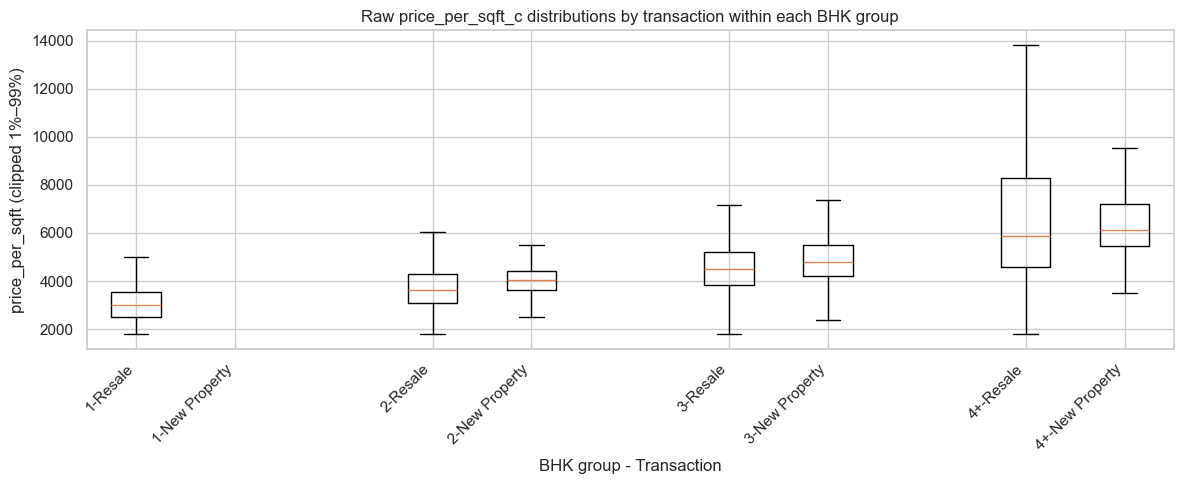

In [43]:
bhk_order = ["1", "2", "3", "4+"]
tx_order = ["Resale", "New Property"]

data = []
labels = []
positions = []
pos = 1

for bhk in bhk_order:
    for tx in tx_order:
        vals = q3_df[
            (q3_df["bhk_group"].astype(str) == bhk) &
            (q3_df["transaction_group"] == tx)
        ]["price_per_sqft_c"].values
        data.append(vals)
        labels.append(f"{bhk}-{tx}")
        positions.append(pos)
        pos += 1
    pos += 1  # gap between BHK groups

plt.figure(figsize=(12, 5))
plt.boxplot(data, positions=positions, showfliers=False)
plt.title("Raw price_per_sqft_c distributions by transaction within each BHK group")
plt.xlabel("BHK group - Transaction")
plt.ylabel("price_per_sqft (clipped 1%–99%)")
plt.xticks(positions, labels, rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### C. Results & Interpretation 

**Visualizations**

**Figure 1**: Pricing uncertainty by segment (IQR of `price_per_sqft_c`)
This bar chart ranks segments (`transaction` × `bhk_group`) by IQR (the spread of the middle 50% of prices). Larger IQR indicates higher pricing uncertainty / heterogeneity within that segment. All values are based on `price_per_sqft_c` (clipped 1%–99%) to reduce extreme-outlier influence.

**Figure 2**: Raw `price_per_sqft_c` distributions by `transaction` within each `bhk_group`
This boxplot shows the full distribution shape (median and spread) for New vs Resale inside each `bhk_group`. It visually confirms which groups are more volatile and whether New/Resale differ in dispersion.

**Quantitative evidence** 

**1) Which segments exhibit the highest pricing uncertainty?**

Using IQR as the primary uncertainty metric, the ranking shows a clear pattern:

- Resale | 4+ is by far the most volatile segment:

    - n = 225, median = 5882, IQR = 3729 (Q1 = 4563, Q3 = 8292).

    - This IQR is more than 2× the next-highest segment, indicating substantial heterogeneity among large resale properties.

- The next tier of uncertainty includes:

    - New Property | 4+: n = 454, median = 6111, IQR = 1724.25

    - Resale | 3: n = 559, median = 4511, IQR = 1408.5

    - New Property | 3: n = 642, median = 4788, IQR = 1301.75

    - Resale | 2: n = 635, median = 3644, IQR = 1221

The most stable segment in the available table is:

- New Property | 2: n = 268, median = 4051, IQR = 772.5
  
**Interpretation**: Pricing uncertainty rises strongly with size/complexity, especially for 4+ BHK. The raw boxplot supports this: the 4+ resale group shows the widest box (IQR) and very long whiskers, suggesting a mix of property qualities/locations that drive wide price variation even after outlier clipping.

**2) Does dispersion differ between New vs Resale within each BHK group?**

We used the Brown–Forsythe test (Levene’s test centered at the median) to compare dispersion between New and Resale within the same BHK group. The results indicate statistically meaningful differences for all tested groups:

- 2 BHK: dispersion differs significantly (stat = 24.74, p ≈ 7.86e-07)

    - IQR(New) = 772.5 vs IQR(Resale) = 1221

    - Ratio = 0.63, meaning New prices are ~37% less dispersed than resale in 2BHK.

- 3 BHK: dispersion differs significantly (stat = 29.21, p ≈ 7.83e-08)

    - IQR(New) = 1301.75 vs IQR(Resale) = 1408.5

    - Ratio = 0.92, a smaller but still meaningful reduction in dispersion for New.

- 4+ BHK: dispersion differs extremely strongly (stat = 85.96, p ≈ 2.42e-19)

    - IQR(New) = 1724.25 vs IQR(Resale) = 3729

    - Ratio = 0.46, meaning New prices are less than half as dispersed as resale in 4+ BHK.

**Interpretation**: Across 2, 3, and 4+ BHK, Resale markets exhibit systematically higher pricing uncertainty than New Property markets, with the gap being especially pronounced for 4+ BHK. Visually, the 4+ resale boxplot is much wider and more spread out than its new-property counterpart.

**Practical meaning and implications**:
- For buyers: High-IQR segments (especially Resale | 4+) imply that listed prices are less consistent; buyers should rely more on close comparables and expect greater negotiation range.

- For agents/platforms: In volatile segments, recommending a price range (e.g., Q1–Q3) is more informative than a single-point estimate.

- For investors: Higher dispersion can indicate larger potential mispricing opportunities, but also higher valuation risk.

**Practical implication**: These areas appear systematically cheaper than the market baseline even after controlling for key listing attributes, which can inform affordability searches, investment screening, or price negotiation strategy.

**Surprises / notable observations**

- The magnitude of uncertainty for Resale | 4+ is striking: IQR = 3729, more than double New | 4+ (IQR = 1724.25) despite similar medians (5882 vs 6111). This suggests that large resale properties in Surat are highly heterogeneous (location, build quality, amenities), whereas new 4+ inventory may be more standardized.

**Limitations**

- Dispersion is measured on clipped price_per_sqft (1%–99%), which improves robustness but may understate extreme volatility in the tails.

- Results are segment-level and do not control for locality or other covariates; dispersion differences may partly reflect different mixes of micro-locations or property attributes within each segment.

- Some segments (e.g., 1 BHK New Property) may be missing due to insufficient sample size under the minimum-n filter; conclusions apply only to segments retained in the analysis.